In [432]:
import numpy as np 
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

## Partie 1. (GMRES)

1. 

In [433]:
def Arnoldi(A, V, H):
    n, p = np.shape(V)
    Vp = np.zeros((n, p + 1))
    Hp = np.zeros((p + 1, p))

    if H.size != 0:
        Hp[:-1, :-1] = H[:, :]
    Vp[:, :-1] = V[:, :]

    Av = A @ V[:, -1]
    for i in range(p):
        Hp[i, -1] = np.dot(Vp[:, i], Av)
    wp = Av - Vp[:, :-1] @ Hp[:-1, -1]
    Hp[-1, -1] = np.linalg.norm(wp)
    Vp[:, -1] = wp / Hp[-1, -1]

    return Vp, Hp

2. 

In [434]:
def gmres(A, b, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x0 = np.zeros(n)          
    r0 = b - A @ x0
    resnorm0 = np.linalg.norm(r0)

    V = np.zeros((n, 1))
    V[:, 0] = r0 / resnorm0
    H = np.zeros((1, 0))

    error_list = []
    residual_list = []

    resnorm = 1.0
    it = 0
    max_iter = max_iter or n
    while (resnorm >= tol) and (it < max_iter):    
        it += 1

        V, H = Arnoldi(A, V, H)

        e1 = np.zeros(H.shape[0])
        e1[0] = resnorm0
        Q, R = np.linalg.qr(H)
        y = np.linalg.solve(R, Q.T @ e1)
        x = x0 + V[:, :-1] @ y

        resnorm = np.linalg.norm(b - A @ x) / resnorm0
        error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)

        error_list.append(error)
        residual_list.append(resnorm)

    return x, error_list, residual_list

3. 

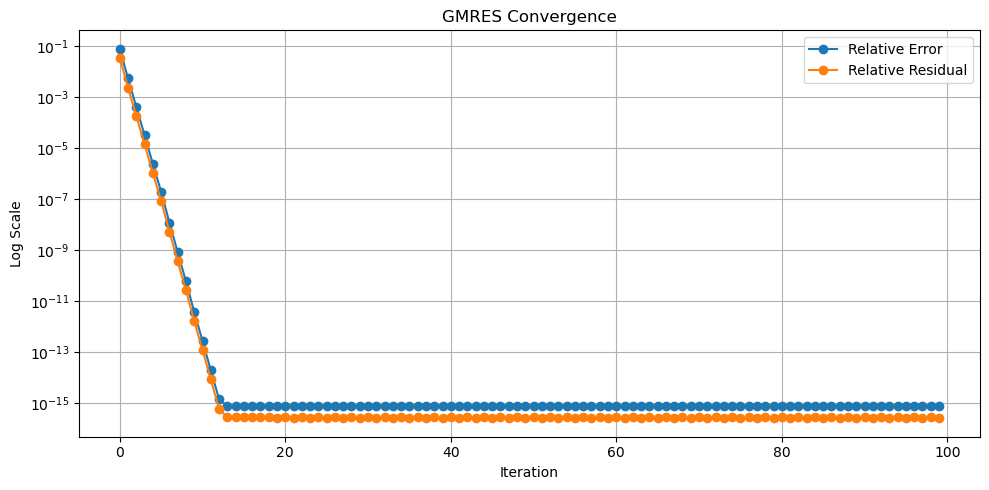

In [435]:
n = 100
A = np.diag(2 * np.ones(n)) + 0.5 * np.random.rand(n, n) / np.sqrt(n)
b = np.ones(n)
x_exact = np.linalg.solve(A, b)

x_approx, error_list, residual_list = gmres(A, b, x_exact, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4. 

In [436]:
def gmres_restart(A, b, x_exact, restart=10, tol=1e-6, max_iter=None):
    n = len(b)
    x = np.zeros(n)
    error_list = []
    residual_list = []
    max_iter = max_iter or n
    total_iter = 0
    r = b - A @ x
    beta = np.linalg.norm(r)

    while total_iter < max_iter and beta > tol * np.linalg.norm(b):
        V = (r / beta).reshape(-1, 1)
        H = np.zeros((0, 0))

        for k in range(restart):
            total_iter += 1

            V, H = Arnoldi(A, V, H)

            m = H.shape[0]
            e1 = np.zeros((m, 1))
            e1[0] = beta
            Q, R = np.linalg.qr(H)
            y = np.linalg.solve(R, Q.T @ e1)
            x_new = x + V[:, :-1] @ y.flatten()

            error = np.linalg.norm(x_exact - x_new) / np.linalg.norm(x_exact)
            rk = b - A @ x_new
            residual = np.linalg.norm(rk) / np.linalg.norm(b)

            error_list.append(error)
            residual_list.append(residual)

            if residual < tol:
                print(f"GMRES with restart converged at iteration {total_iter}")
                return x_new, error_list, residual_list

        x = x_new
        r = b - A @ x
        beta = np.linalg.norm(r)

    return x, error_list, residual_list

GMRES with restart converged at iteration 91


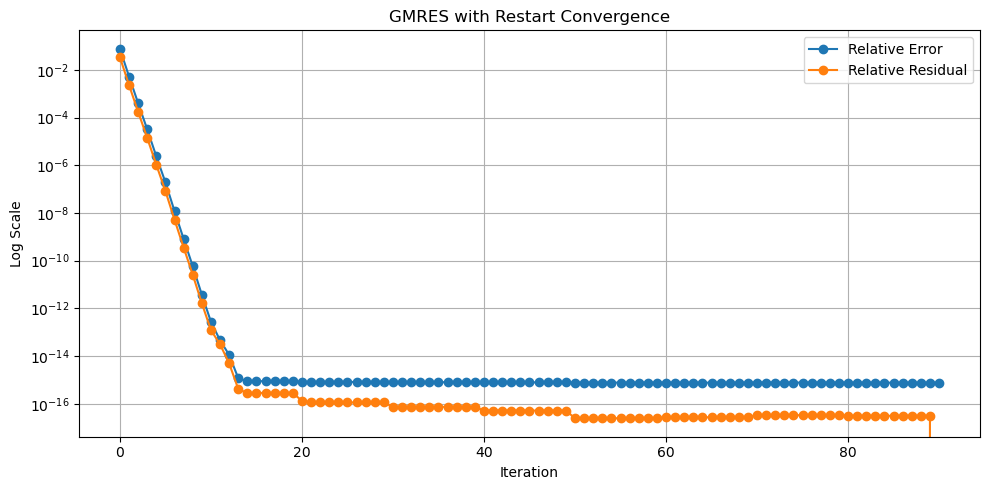

In [437]:
xk, error_list, residual_list = gmres_restart(A, b, x_exact, restart=10, tol=1e-18, max_iter=100)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Restart Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Partie 2. (Gradient Conjugué) 

5. 

In [438]:
def gradient_conjugue(A, b, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x = np.zeros(n)

    r = b - A @ x
    d = r.copy()

    error_list = []
    residual_list = []

    resnorm0 = np.linalg.norm(r)
    if resnorm0 == 0:
        return x, [0], [0]

    resnorm = resnorm0
    max_iter = max_iter or n
    it = 0

    while resnorm / resnorm0 > tol and it < max_iter:
        it += 1

        Ad = A @ d
        r_dot_r = np.dot(r, r)
        alpha = r_dot_r / np.dot(d, Ad)

        x = x + alpha * d

        r_new = r - alpha * Ad

        resnorm = np.linalg.norm(r_new)
        err = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)

        error_list.append(err)
        residual_list.append(resnorm / resnorm0)

        beta = np.dot(r_new, r_new) / r_dot_r
        d = r_new + beta * d

        r = r_new

    return x, error_list, residual_list

6. 

In [439]:
d = 50
n = d**2

B = spsp.diags([[4.]*n, [-1]*(n-1), [-1]*(n-1), [-1]*(n-d), [-1]*(n-d)], [0, 1, -1, d, -d])

/tmp/ipykernel_70801/3111109319.py:5: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x_exact = spsp.linalg.spsolve(B, b)
/tmp/ipykernel_70801/3111109319.py:12: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x_gmres, info = gmres(B, b, tol=1e-6)


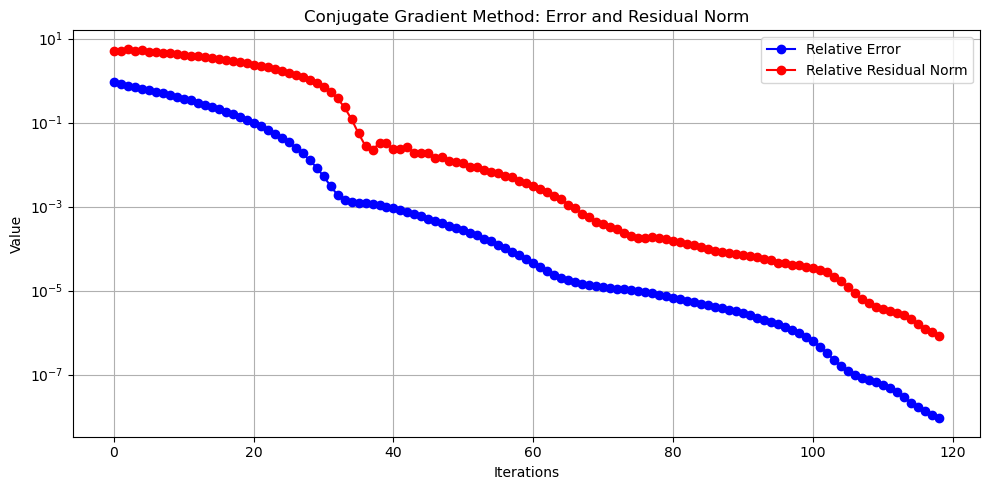

Conjugate Gradient method computation time: 0.0040 seconds
GMRES method computation time: 0.1144 seconds


In [440]:
import time
from scipy.sparse.linalg import gmres

b = np.ones(n)
x_exact = spsp.linalg.spsolve(B, b)

start_time = time.time()
x_cg, error_list_cg, residual_list_cg = gradient_conjugue(B, b, x_exact)
cg_time = time.time() - start_time

start_time = time.time()
x_gmres, info = gmres(B, b, tol=1e-6)
gmres_time = time.time() - start_time

plt.figure(figsize=(10, 5))

plt.semilogy(error_list_cg, marker='o', label='Relative Error', color='blue')
plt.semilogy(residual_list_cg, marker='o', label='Relative Residual Norm', color='red')

plt.title('Conjugate Gradient Method: Error and Residual Norm')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Conjugate Gradient method computation time: {cg_time:.4f} seconds")
print(f"GMRES method computation time: {gmres_time:.4f} seconds")

La méthode CG ne stocke pas tous les vecteurs de base du sous-espace de Krylov, ce qui est l'une des raisons pour lesquelles elle est plus efficace que la méthode GMRES sur les matrices définies positives symétriques clairsemées.

## Partie 3. (Préconditionnement)

7. 

In [441]:
def gmres_preconditioned(A, b, M, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x0 = np.zeros(n)
    r0 = b - A @ x0
    z0 = np.linalg.solve(M, r0)
    beta = np.linalg.norm(z0)

    V = (z0 / beta).reshape(-1, 1)
    H = np.zeros((0, 0))

    error_list = []
    residual_list = []

    res_norm = beta
    iter_count = 0
    max_iter = max_iter or n

    while res_norm >= tol and iter_count < max_iter:
        iter_count += 1

        V, H = Arnoldi(A, V, H)

        e1 = np.zeros(H.shape[0])
        e1[0] = beta

        y, _, _, _ = np.linalg.lstsq(H, e1, rcond=None)
        x = x0 + V[:, :-1] @ y

        r = b - A @ x
        z = np.linalg.solve(M, r)
        res_norm = np.linalg.norm(z)
        error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)

        error_list.append(error)
        residual_list.append(res_norm / beta)

    return x, error_list, residual_list

/tmp/ipykernel_70801/1614442419.py:12: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x, erro= gmres(C, b, tol=1e-18)


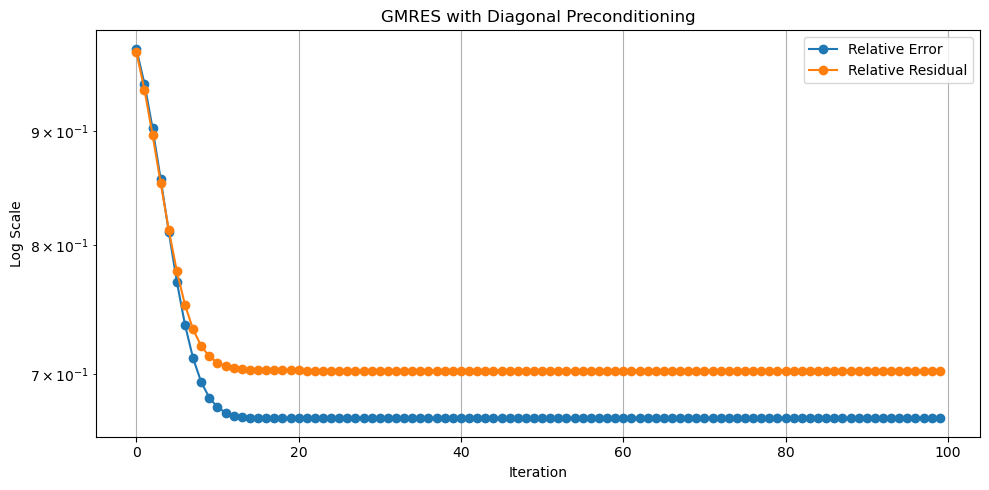

In [ ]:
n = 100
C = np.diag(2 + np.arange(n)) - np.diag(np.ones(n-1), 1) - np.diag(np.ones(n-1), -1)
M = np.diag(np.diag(C))
b = np.ones(n)
x_exact = np.linalg.solve(C, b)

start_time = time.time()
x_approx, error_list, residual_list = gmres_preconditioned(C, b, M, x_exact, tol=1e-18)
gp_time = time.time() - start_time

start_time = time.time()
x, erro= gmres(C, b, tol=1e-18)
gm_time = time.time() - start_time

plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Diagonal Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [443]:
cond_C = np.linalg.cond(C)
cond_MC = np.linalg.cond(np.linalg.inv(M) @ C)
print(f"Condition number of C: {cond_C}")
print(f"Condition number of M⁻¹C: {cond_MC}")

print(f"gmres preconditioned method computation time: {gp_time:.4f} seconds")
print(f"GMRES method computation time: {gm_time:.4f} seconds")

Condition number of C: 81.14988205949659
Condition number of M⁻¹C: 3.2409851646203016
gmres preconditioned method computation time: 0.0827 seconds
GMRES method computation time: 2.4351 seconds


Plus rapide après le prétraitement

8. 

/tmp/ipykernel_70801/2044698231.py:12: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x, erro= gmres(C, b, tol=1e-18)


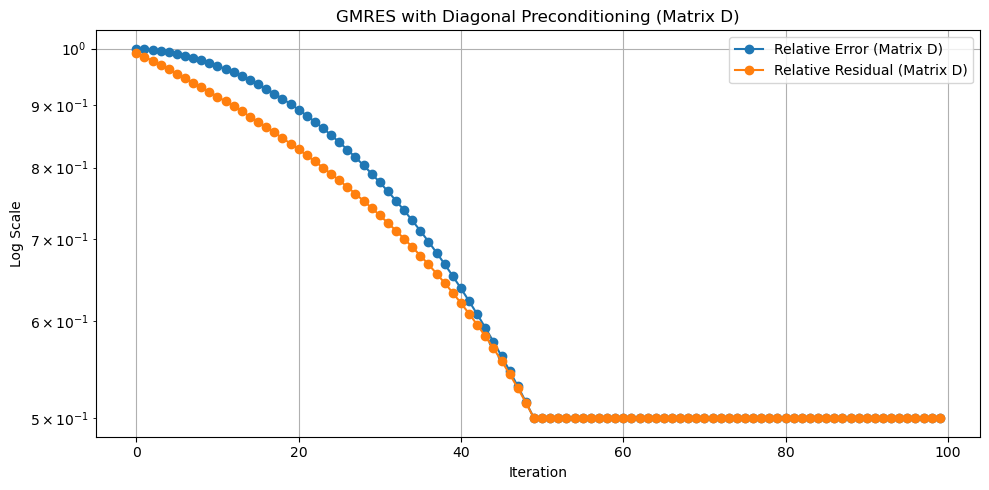

In [ ]:
n = 100
D = np.diag(2 * np.ones(n)) - np.diag(np.ones(n-1), 1) - np.diag(np.ones(n-1), -1)
M_D = np.diag(np.diag(D))
b = np.ones(n)
x_exact_D = np.linalg.solve(D, b)

start_time = time.time()
x_approx_D, error_list_D, residual_list_D = gmres_preconditioned(D, b, M_D, x_exact_D, tol=1e-18)
gp_time = time.time() - start_time

start_time = time.time()
x, erro= gmres(C, b, tol=1e-18)
gm_time = time.time() - start_time

plt.figure(figsize=(10, 5))
plt.semilogy(error_list_D, marker='o', label='Relative Error (Matrix D)')
plt.semilogy(residual_list_D, marker='o', label='Relative Residual (Matrix D)')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Diagonal Preconditioning (Matrix D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [445]:
cond_D = np.linalg.cond(D)
cond_MD = np.linalg.cond(np.linalg.inv(M_D) @ D)
print(f"Condition number of D: {cond_D}")
print(f"Condition number of M⁻¹D: {cond_MD}")

print(f"gmres preconditioned method computation time: {gp_time:.4f} seconds")
print(f"GMRES method computation time: {gm_time:.4f} seconds")

Condition number of D: 4133.642926801396
Condition number of M⁻¹D: 4133.642926801396
gmres preconditioned method computation time: 0.0818 seconds
GMRES method computation time: 2.4371 seconds


Plus rapide après le prétraitement

9. 

In [446]:
def conjugate_gradient_precond(A, b, M, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    z = M @ r
    d = z.copy()
    error_list = []
    residual_list = []

    res_norm = np.linalg.norm(r)
    initial_res_norm = res_norm
    iter_count = 0
    max_iter = max_iter or n

    while res_norm >= tol * initial_res_norm and iter_count < max_iter:
        iter_count += 1
        Ad = A @ d
        alpha = np.dot(r, z) / np.dot(d, Ad)
        x = x + alpha * d
        r_new = r - alpha * Ad
        z_new = M @ r_new
        
        beta = np.dot(r_new, z_new) / np.dot(r, z)
        d = z_new + beta * d
        
        r = r_new
        z = z_new
        res_norm = np.linalg.norm(r)

        error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
        error_list.append(error)
        residual_list.append(res_norm / initial_res_norm)

    return x, error_list, residual_list


/tmp/ipykernel_70801/3107053104.py:5: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x_exact_B = spsplin.spsolve(B, b)


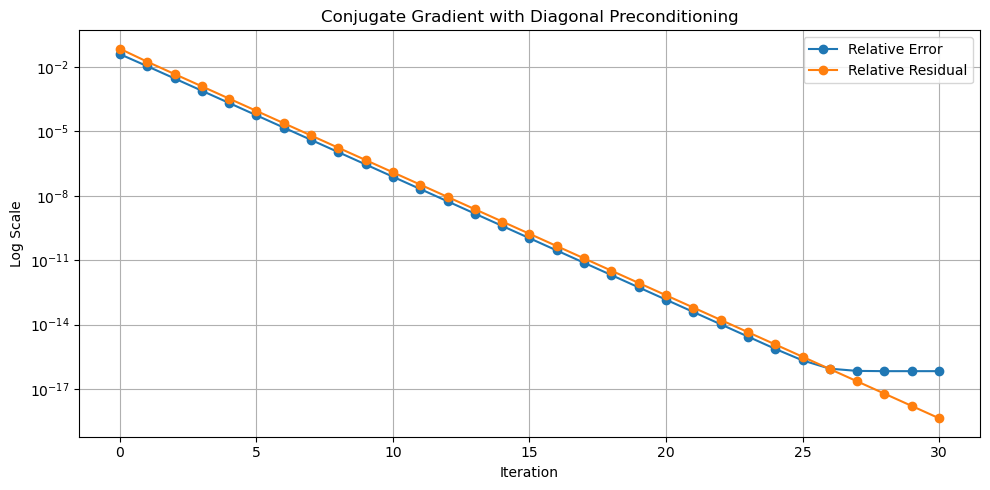

In [ ]:
n = 100
B = spsp.diags([[4.]*n, [-1]*(n-1), [-1]*(n-1)], [0, 1, -1])
M_B = spsp.diags([[4.]*n], [0])
b = np.ones(n)
x_exact_B = spsplin.spsolve(B, b)

x_approx_B, error_list_B, residual_list_B = conjugate_gradient_precond(B.toarray(), b, M_B.toarray(), x_exact_B, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list_B, marker='o', label='Relative Error')
plt.semilogy(residual_list_B, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Conjugate Gradient with Diagonal Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

10. 

/tmp/ipykernel_70801/846327419.py:3: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(B)


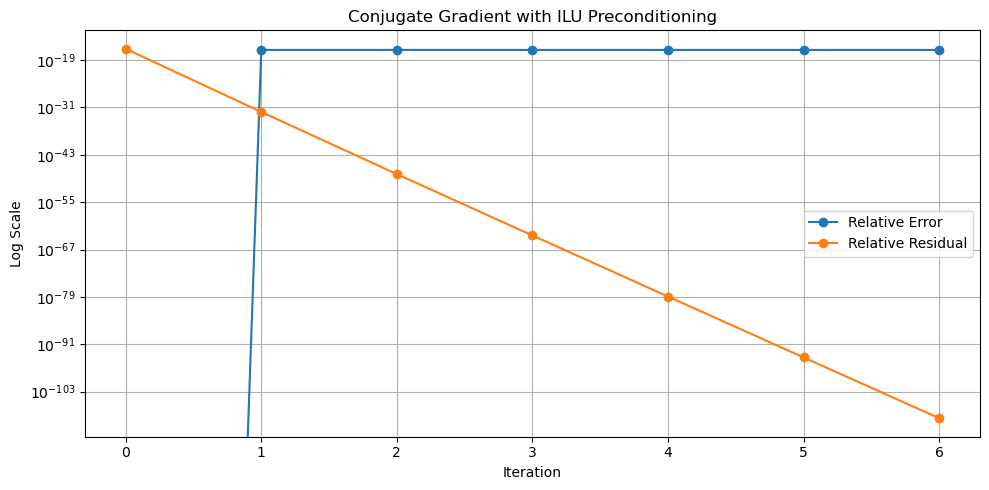

Conjugate Gradient method computation time: 0.0020 seconds
Conjugate Gradient precond method computation time: 0.0008 seconds


In [448]:
from scipy.sparse.linalg import spilu, LinearOperator

ilu = spilu(B)
M = LinearOperator(B.shape, matvec=ilu.solve)

start_time = time.time()
x_approx, error_list, residual_list = conjugate_gradient_precond(B.toarray(), b, M, x_exact_B, tol=1e-100)
cgp_time = time.time() - start_time

start_time = time.time()
x_cg, error_list_cg, residual_list_cg = gradient_conjugue(B, b, x_exact, tol=1e-100)
cg_time = time.time() - start_time


plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Conjugate Gradient with ILU Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Conjugate Gradient method computation time: {cg_time:.4f} seconds")
print(f"Conjugate Gradient precond method computation time: {cgp_time:.4f} seconds")

Plus rapide après le prétraitement